# Connecting to Drive and Unzipping Files
---

In [1]:
import os
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_path = '/content/drive/MyDrive/Job market analysis/archive.zip'
extract_path = '/content/drive/MyDrive/Job market analysis/Unzipped_Files'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zipped_files:
  zipped_files.extractall(extract_path)

print(f"Extracted files to: {extract_path}")

Extracted files to: /content/drive/MyDrive/Job market analysis/Unzipped_Files


In [4]:
all_paths = []

for root, dirs, files in os.walk(extract_path):
  for d in dirs:
    if d.endswith('.csv'):
      path = os.path.join(root, d)
      all_paths.append(path)
      print(path)

  for f in files:
    if f.endswith('.csv'):
      path = os.path.join(root, f)
      all_paths.append(path)
      print(path)

/content/drive/MyDrive/Job market analysis/Unzipped_Files/postings.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/companies.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/company_industries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/company_specialities.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/employee_counts.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/benefits.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/job_industries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/job_skills.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/salaries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/mappings/industries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/mappings/skills.csv


# Understanding our Data
---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Image

In [6]:
# Create all necessary datframes
positions_df            = pd.read_csv(all_paths[0])
companies_df            = pd.read_csv(all_paths[1])
company_industries_df   = pd.read_csv(all_paths[2])
company_specialities_df = pd.read_csv(all_paths[3])
employee_counts_df      = pd.read_csv(all_paths[4])
benefits_df             = pd.read_csv(all_paths[5])
job_industries_df       = pd.read_csv(all_paths[6])
job_skills_df           = pd.read_csv(all_paths[7])
salaries_df             = pd.read_csv(all_paths[8])
industries_df           = pd.read_csv(all_paths[9])
skills_df               = pd.read_csv(all_paths[10])

In [7]:
def explore(title, df):
  display(Markdown(title))
  display(df.head(10))
  display(Markdown('## Descriptive Statistics'))
  display(df.describe())
  display(Markdown('## Missing Values'))
  display(df.isnull().sum().sort_values(ascending=False))
  display(Markdown('## Data Types'))
  display(df.dtypes)
  display(Markdown('## Shape'))
  display(df.shape)

# explore('# Positions Dataframe', positions_df)
# explore('# Companies Dataframe', companies_df)
# explore('# Company Industries Dataframe', company_industries_df)
# explore('# Company Specialities Dataframe', company_specialities_df)
# explore('# Employee counts Dataframe', employee_counts_df)
# explore('# Benefits Dataframe', benefits_df)
# explore('# Job Industries Dataframe', job_industries_df)
# explore('# Job Skills Dataframe', job_skills_df)
# explore('# Salaries Dataframe', salaries_df)
# explore('# Industries Dataframe', industries_df)
# explore('# Skills Dataframe', skills_df)

- Positions dataframe can be linked to companies datframe using company id, the latter datframe provides more information on a company such as name (some comapny name values are missing in positions datframes, companies dataframes accounts for that), company location, size and company description. Note: Location in Positions dataframe stands for hiring locaion and not company location.
- Positions datframe can be linked to company industries dataframe using company id, it also has no missing values, it highlights what industry a job falls into e.g. company Optima Bio Supply Ltd, id no. 93223209.0 falls under the 	Medical Equipment Manufacturing industry and SynergisticIT, id no. 66321745.0 falls under IT Services and IT Consulting.
- Company specialities dataframes provides niches that companies specialize in such as SynergisticIT, id no. 66321745.0, which specializes in Software development, IT Recruitment and IT Upskill and SSi People, id no. 56833.0 that specializes in IT Staffing/Consulting, .NET, mainframe, Unix, Linux, Oracle, SQL etc. This dataframe can be used to source skills relevant to a company, industry or job title.
- Employee count dataframe provides employee count per company over time whereby the recorded employee count has a unix time as to when it was recorded.
- Benefits dataframes which contains job id contains information on benefits allocated to cerain jobs e.g. 401K, medical insurance, dental insurance etc.
- Job industries dataframe links unique job id's to industry id's differnt from company industries that shows what industry a company belongs to this can used to niche down on a specific job titles role in the indutry. It is further connected to industries dataframe that connects the unique industry Id's to their industry names.
- Positions dataframe can be linked to job skills dataframe using job id which shows what category a job falls into e.g ENG for engineering, IT for information technology and ADM for admimistration. Job id has no missing values in both positions and job skills dataframes.
- salaries dataframe provides salary data e.g. compensation tpe, currency, pay period, max and min salary values (with reletively many missing values) and a unique salary id that links to each job id.


# Data Cleaning
---

In [9]:
# Get a list of valid company_ids from the companies_df
valid_company_ids = companies_df['company_id'].tolist()

# Filter the positions_df to keep only rows with valid company_ids
positions_df_filtered = positions_df[positions_df['company_id'].isin(valid_company_ids)]

print("Filtered positions data successfully.")
print(f"\nOriginal dataset shape: {positions_df.shape}")
print(f"Filtered dataset shape: {positions_df_filtered.shape}")
print(f"Percentage lost is: {(1 - (len(positions_df_filtered) / len(positions_df)))*100:.3f}%")
print(f"Missing values in company id column: {positions_df_filtered["company_id"].isnull().sum()}")

Filtered positions data successfully.

Original dataset shape: (123849, 31)
Filtered dataset shape: (122131, 31)
Percentage lost is: 1.387%
Missing values in company id column: 0


In [25]:
print(companies_df['company_id'].nunique())
print(companies_df.shape)

24473
(24473, 10)


# Creating a sqlite database
---

In [10]:
!pip install eralchemy

In [11]:
import sqlite3
import csv
import eralchemy

In [20]:
conn = sqlite3.connect('linkedin_jobs.db')
cur  = conn.cursor()
cur.execute("PRAGMA foreign_keys = ON;")

In [21]:
def load_df_to_sqlite(df, table_name, schema, conn, cur):
    # Create table if it doesn't exist
    cur.execute(f"CREATE TABLE IF NOT EXISTS {table_name} {schema}")

    # Build INSERT statement
    columns = [f'"{col}"' for col in df.columns]  # Enclose column names in quotes
    placeholders = ", ".join(["?"] * len(columns))
    insert_sql = f"INSERT OR IGNORE INTO {table_name} ({', '.join(columns)}) VALUES ({placeholders})"

    # Insert rows from DataFrame
    for _, row in df.iterrows():
        values = tuple(row[col.strip('"')] for col in columns)  # Match dict style
        cur.execute(insert_sql, values)

    conn.commit()

In [22]:
companies_schema = """(
  company_id INTEGER PRIMARY KEY,
  name TEXT,
  description TEXT,
  company_size REAL,
  state TEXT,
  country TEXT,
  city TEXT,
  zip_code TEXT,
  address TEXT,
  url TEXT
)"""

load_df_to_sqlite(companies_df, 'companies', companies_schema, conn, cur)

In [23]:
positions_schema = """(
  job_id INTEGER PRIMARY KEY,
  company_name TEXT,
  title TEXT,
  description TEXT,
  max_salary REAL,
  pay_period TEXT,
  location TEXT,
  company_id INTEGER,
  views REAL,
  med_salary REAL,
  min_salary REAL,
  formatted_work_type TEXT,
  applies REAL,
  original_listed_time REAL,
  remote_allowed REAL,
  job_posting_url TEXT,
  application_url TEXT,
  application_type TEXT,
  expiry REAL,
  closed_time REAL,
  formatted_experience_level TEXT,
  skills_desc TEXT,
  listed_time REAL,
  posting_domain TEXT,
  sponsored INTEGER,
  work_type TEXT,
  currency TEXT,
  compensation_type TEXT ,
  normalized_salary REAL,
  zip_code REAL,
  fips REAL,
  FOREIGN KEY (company_id) REFERENCES companies(company_id)
  )"""

load_df_to_sqlite(positions_df_filtered, 'positions', positions_schema, conn, cur)

In [26]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('companies',), ('positions',)]


In [17]:
# cur.execute("PRAGMA table_info(positions);")
# for row in cur.fetchall():
#     print(row)

(0, 'job_id', 'INTEGER', 0, None, 1)
(1, 'company_name', 'TEXT', 0, None, 0)
(2, 'title', 'TEXT', 0, None, 0)
(3, 'description', 'TEXT', 0, None, 0)
(4, 'max_salary', 'REAL', 0, None, 0)
(5, 'pay_period', 'TEXT', 0, None, 0)
(6, 'location', 'TEXT', 0, None, 0)
(7, 'company_id', 'INTEGER', 0, None, 0)
(8, 'views', 'REAL', 0, None, 0)
(9, 'med_salary', 'REAL', 0, None, 0)
(10, 'min_salary', 'REAL', 0, None, 0)
(11, 'formatted_work_type', 'TEXT', 0, None, 0)
(12, 'applies', 'REAL', 0, None, 0)
(13, 'original_listed_time', 'REAL', 0, None, 0)
(14, 'remote_allowed', 'REAL', 0, None, 0)
(15, 'job_posting_url', 'TEXT', 0, None, 0)
(16, 'application_url', 'TEXT', 0, None, 0)
(17, 'application_type', 'TEXT', 0, None, 0)
(18, 'expiry', 'REAL', 0, None, 0)
(19, 'closed_time', 'REAL', 0, None, 0)
(20, 'formatted_experience_level', 'TEXT', 0, None, 0)
(21, 'skills_desc', 'TEXT', 0, None, 0)
(22, 'listed_time', 'REAL', 0, None, 0)
(23, 'posting_domain', 'TEXT', 0, None, 0)
(24, 'sponsored', 'INTEGER

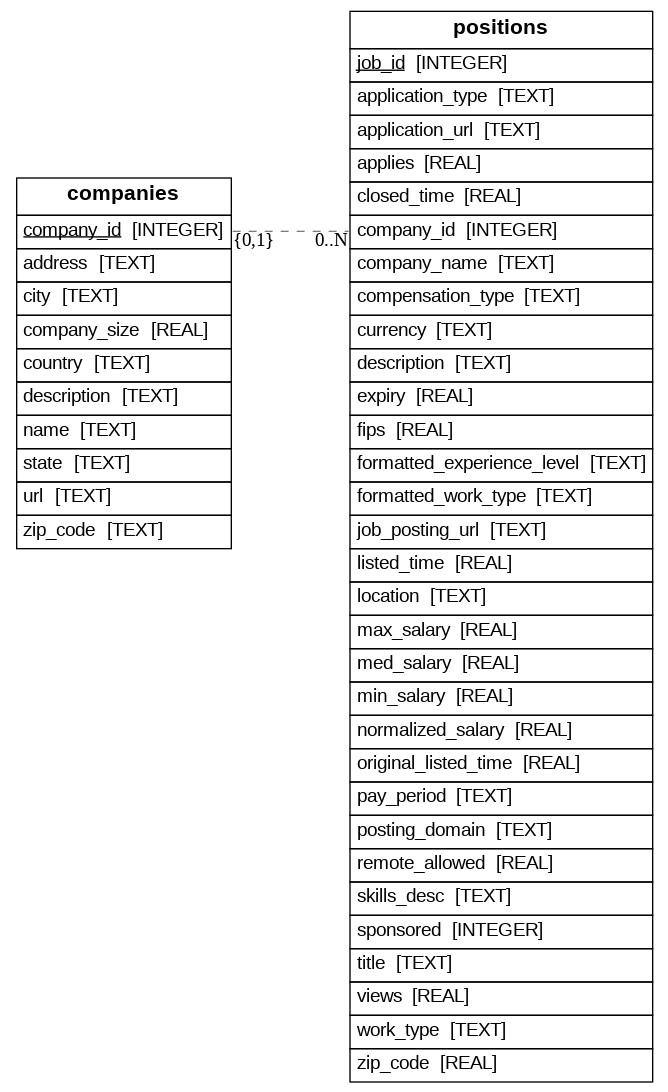

In [27]:
!cp linkedin_jobs.db tmp_linkedin_jobs.db
!eralchemy -i sqlite:///tmp_linkedin_jobs.db -o linkedin_jobs_erd.dot
!dot -Tpng linkedin_jobs_erd.dot -o linkedin_jobs_erd.png
Image(filename='/content/linkedin_jobs_erd.png')